In [ ]:
# from google.colab import drive
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import random
import numpy as np
from scipy import signal
import numpy as np
# import numexpr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from keras.layers import *
from keras.models import *
from sklearn.preprocessing import MinMaxScaler
# import h5py

from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/MyDrive/Traffic_data'

Mounted at /content/drive


In [ ]:
#  import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# seed = 1024
# nrows = 150159
nrows = 150159
feature_names = ['ego_x',"ego_v", 'f_dx', 'f_dy', 'f_dv', 'b_dx', 'b_dy','b_dv', 'l_dx', 'l_dy', 'l_dv', 'r_dx', 'r_dy', 'r_dv']
# Label1: Ego vehicle lateral displacement
label_names_1 = ['ego_x']

# Label2: Ego vehicle longitudinal velocity
label_names_2 = ['ego_v']
# label_name = 'ego_v'
time_columns = "index"

full_path = Path+'/Final_result.xlsx' 

###############################
# nrows = 150158+1
################################

train_rows=int(nrows*0.8) 
epoch_no = 50
batch_size_RNN = 32
n_in = 10 
n_out = 5

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from sklearn.preprocessing import MinMaxScaler
import h5py
df = pd.read_excel(full_path,parse_dates=[time_columns],nrows=nrows)
df = df.sort_values(time_columns)
df.index = np.arange(df.shape[0])

In [ ]:
df2=df.iloc[:,:]

In [ ]:
df2

,index,ego_x,ego_v,f_dx,f_dy,f_dv,b_dx,b_dy,b_dv,l_dx,l_dy,l_dv,r_dx,r_dy,r_dv
0,0,51.816071,34.006429,30.000000,300.000000,0.000000,0.561490,0.561490,2.236814,-13.171722,-13.171722,0.154693,30.000000,300.000000,0.000000
1,1,52.726857,35.324286,30.000000,300.000000,0.000000,-1.311634,-1.311634,-0.999323,-13.838332,-13.838332,-0.283392,30.000000,300.000000,0.000000
2,2,53.001810,37.491429,30.000000,300.000000,0.000000,-2.030706,-2.030706,-4.150722,-13.980892,-13.980892,-2.208976,30.000000,300.000000,0.000000
3,3,56.291381,39.865238,30.000000,300.000000,0.000000,-5.374435,-5.374435,-6.864538,-17.218590,-17.218590,-4.814726,30.000000,300.000000,0.000000
4,4,29.079835,33.970674,30.000000,300.000000,0.000000,1.012832,1.012832,2.269220,-10.292661,-10.292661,4.718274,9.564515,9.564515,0.190448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150153,150153,54.884292,31.266600,0.995212,0.995212,0.556859,30.000000,-300.000000,0.000000,-11.886239,-11.886239,-10.740936,30.000000,300.000000,0.000000
150154,150154,55.487412,30.799086,0.924888,0.924888,-0.160062,30.000000,-300.000000,0.000000,-12.521460,-12.521460,-10.482866,30.000000,300.000000,0.000000
150155,150155,55.763696,30.041457,0.977016,0.977016,-0.019488,30.000000,-300.000000,0.000000,-13.144927,-13.144927,-10.134691,30.000000,300.000000,0.000000
150156,150156,55.801684,29.671496,1.002816,1.002816,0.807027,30.000000,-300.000000,0.000000,-13.494337,-13.494337,-10.132686,30.000000,300.000000,0.000000


In [ ]:
#Normalization
scaler_y_1 = MinMaxScaler(feature_range=(-1, 1))
scaler_y_1.fit(df2[label_names_1].values.astype(float))

scaler_y_2 = MinMaxScaler(feature_range=(-1, 1))
scaler_y_2.fit(df2[label_names_2].values.astype(float))

scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_x.fit(df2[feature_names].values.astype(float))

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
## Create dataset
def create_dataset(df,feature_names,label_names_1,label_names_2,n_in,n_out,scaler_x=None,scaler_y_1 = None,scaler_y_2 = None):
  X, Y1, Y2 = [], [], []
  for i in tqdm(range(df.shape[0]-n_in-n_out+1)):
    # x_train.append(np.array(df[feature_names].iloc[i:i+n_in]))
    x = df[feature_names].values[i:i+n_in].astype(float)
    x = scaler_x.transform(x)
    label1 = df[label_names_1].values[i+n_in:i+n_in+n_out].astype(float)
    label1 = scaler_y_1.transform(label1)
    label2 = df[label_names_2].values[i+n_in:i+n_in+n_out].astype(float)
    label2 = scaler_y_2.transform(label2)
    # label = scaler_y.transform(label.reshape(-1,1)).reshape(-1)
    X.append(x)
    Y1.append(label1)
    Y2.append(label2)

    # break
  return np.array(X),np.array(Y1),np.array(Y2)

In [ ]:
X_1,Y1,Y2 = create_dataset(df2,feature_names,label_names_1,label_names_2,n_in,n_out,scaler_x,scaler_y_1,scaler_y_2)

100%|██████████| 150144/150144 [17:43<00:00, 141.24it/s]


In [ ]:
x1_train, x1_test = X_1[:train_rows], X_1[train_rows:]
y1_train, y1_test = Y1[:train_rows], Y1[train_rows:]
y2_train, y2_test = Y2[:train_rows], Y2[train_rows:]
print(x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape,y2_train.shape,y2_test.shape)

(120127, 10, 14) (30017, 10, 14) (120127, 5, 1) (30017, 5, 1) (120127, 5, 1) (30017, 5, 1)


In [ ]:
# out=5,y1 ae-lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector,TimeDistributed
y1_train=y1_train.reshape((y1_train.shape[0],y1_train.shape[1]))
# Initialising the RNN
regressor_x = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=100
regressor_x.add(Bidirectional(LSTM(units = layer_1_units, input_shape = (x1_train.shape[1], x1_train.shape[2]))))
regressor_x.add(RepeatVector(5))
regressor_x.add(Bidirectional(LSTM(layer_1_units, activation='relu', return_sequences=True)))
regressor_x.add(TimeDistributed(Dense(1)))

# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor_x.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# epoch_no=20
# batch_size_RNN=64
model_x = regressor_x.fit(x1_train, y1_train, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/50
3754/3754 [==============================] - 117s 29ms/step - loss: 0.0212
Epoch 2/50
3754/3754 [==============================] - 111s 30ms/step - loss: 0.0191
Epoch 3/50
3754/3754 [==============================] - 111s 30ms/step - loss: 0.0188
Epoch 4/50
3754/3754 [==============================] - 111s 30ms/step - loss: 0.0185
Epoch 5/50
3754/3754 [==============================] - 110s 29ms/step - loss: 0.0182
Epoch 6/50
3754/3754 [==============================] - 110s 29ms/step - loss: 0.0179
Epoch 7/50
3754/3754 [==============================] - 110s 29ms/step - loss: 0.0176
Epoch 8/50
3754/3754 [==============================] - 110s 29ms/step - loss: 0.0174
Epoch 9/50
3754/3754 [==============================] - 110s 29ms/step - loss: 0.0173
Epoch 10/50
3754/3754 [==============================] - 109s 29ms/step - loss: 0.0171
Epoch 11/50
3754/3754 [==============================] - 110s 29ms/step - loss: 0.0169
Epoch 12/50
3754/3754 [=============================

In [ ]:
# out=10,y2 ae-lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector,TimeDistributed
y2_train=y2_train.reshape((y2_train.shape[0],y2_train.shape[1]))
# Initialising the RNN
regressor_v = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=100
regressor_v.add(Bidirectional(LSTM(units = layer_1_units, input_shape = (x1_train.shape[1], x1_train.shape[2]))))
regressor_v.add(RepeatVector(5))
regressor_v.add(Bidirectional(LSTM(layer_1_units, activation='relu', return_sequences=True)))
regressor_v.add(TimeDistributed(Dense(1)))

# regressor.add(Dense(units =(y_train.shape[1], y_train.shape[2])))

# Compiling the RNN
regressor_v.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# epoch_no=20
# batch_size_RNN=64
model_v = regressor_v.fit(x1_train, y2_train, epochs = epoch_no, batch_size = batch_size_RNN)

Epoch 1/50
3754/3754 [==============================] - 123s 31ms/step - loss: 0.0090
Epoch 2/50
3754/3754 [==============================] - 116s 31ms/step - loss: 0.0062
Epoch 3/50
3754/3754 [==============================] - 116s 31ms/step - loss: 0.0058
Epoch 4/50
3754/3754 [==============================] - 114s 30ms/step - loss: 0.0055
Epoch 5/50
3754/3754 [==============================] - 112s 30ms/step - loss: 0.0053
Epoch 6/50
3754/3754 [==============================] - 113s 30ms/step - loss: 0.0051
Epoch 7/50
3754/3754 [==============================] - 112s 30ms/step - loss: 0.0049
Epoch 8/50
3754/3754 [==============================] - 112s 30ms/step - loss: 0.0048
Epoch 9/50
3754/3754 [==============================] - 111s 30ms/step - loss: 0.0047
Epoch 10/50
3754/3754 [==============================] - 111s 30ms/step - loss: 0.0045
Epoch 11/50
3754/3754 [==============================] - 111s 30ms/step - loss: 0.0044
Epoch 12/50
3754/3754 [=============================

In [ ]:
trainPredict_x = regressor_x.predict(x1_train)
trainPredict_v = regressor_v.predict(x1_train)

trainPredict_x = trainPredict_x.reshape(trainPredict_x.shape[0],trainPredict_x.shape[1])
trainPredict_v = trainPredict_v.reshape(trainPredict_v.shape[0],trainPredict_v.shape[1])

y1_train_cnt =  scaler_y_1.inverse_transform(y1_train.reshape(-1, n_out))
y2_train_cnt =  scaler_y_2.inverse_transform(y2_train.reshape(-1, n_out))

trainPredict_x_cnt = scaler_y_1.inverse_transform(trainPredict_x)
trainPredict_v_cnt = scaler_y_2.inverse_transform(trainPredict_v)

In [ ]:
testPredict_x = regressor_x.predict(x1_test)
testPredict_v = regressor_v.predict(x1_test)

testPredict_x = testPredict_x.reshape(testPredict_x.shape[0],testPredict_x.shape[1])
testPredict_v = testPredict_v.reshape(testPredict_v.shape[0],testPredict_v.shape[1])

y1_test_cnt =  scaler_y_1.inverse_transform(y1_test.reshape(-1, n_out))
y2_test_cnt =  scaler_y_2.inverse_transform(y2_test.reshape(-1, n_out))

testPredict_x_cnt = scaler_y_1.inverse_transform(testPredict_x)
testPredict_v_cnt = scaler_y_2.inverse_transform(testPredict_v)

<function matplotlib.pyplot.show>

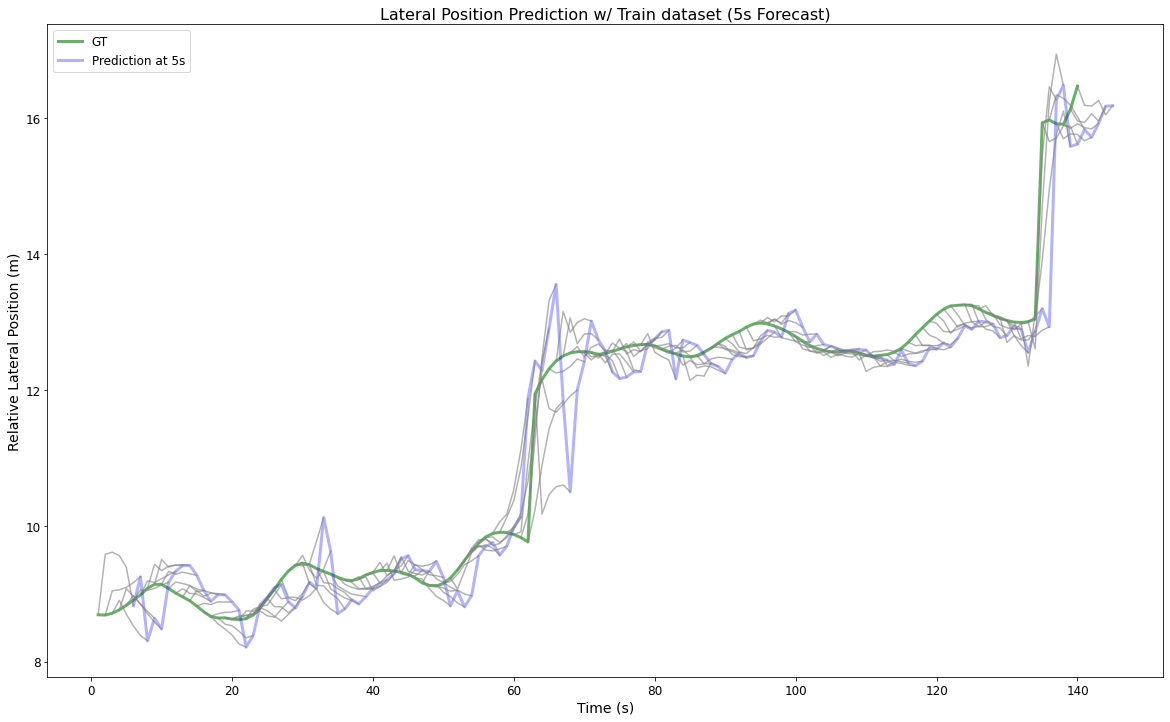

In [ ]:
plt.figure(figsize=(20, 12))  
plt.plot(range(1,141),y1_train_cnt[2210:2350,0]/3.28084,'green',label='GT',linewidth = 3, alpha=0.6)
plt.plot(range(6,146),trainPredict_x_cnt[2210:2350,4]/3.28084,'blue',label='Prediction at 5s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2210,2350):
  traj = np.insert(trainPredict_x_cnt[i][:], 0, y1_train_cnt[2210:2350,0][m-1], axis=0)
  plt.plot(range(m,m+6),traj/3.28084,'gray', alpha=0.6)
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Train dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

<function matplotlib.pyplot.show>

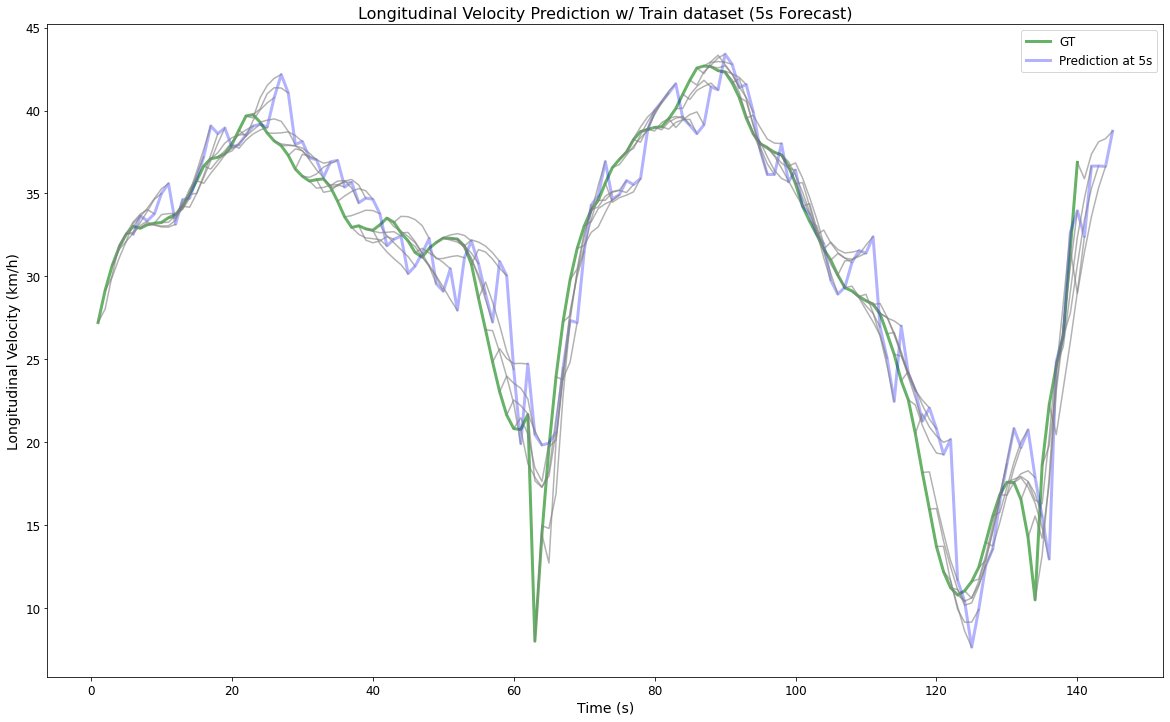

In [ ]:
plt.figure(figsize=(20, 12))  
plt.plot(range(1,141),y2_train_cnt[2210:2350,0]*1.09728,'green',label='GT',linewidth = 3, alpha=0.6)
plt.plot(range(6,146),trainPredict_v_cnt[2210:2350,4]*1.09728,'blue',label='Prediction at 5s',linewidth = 3, alpha=0.3)
m = 1
for i in range(2210,2350):
  traj = np.insert(trainPredict_v_cnt[i][:], 0, y2_train_cnt[2210:2350,0][m-1], axis=0)
  plt.plot(range(m,m+6),traj*1.09728,'gray', alpha=0.6)
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Longitudinal Velocity Prediction w/ Train dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Longitudinal Velocity (km/h)', fontsize='14')
plt.show

<function matplotlib.pyplot.show>

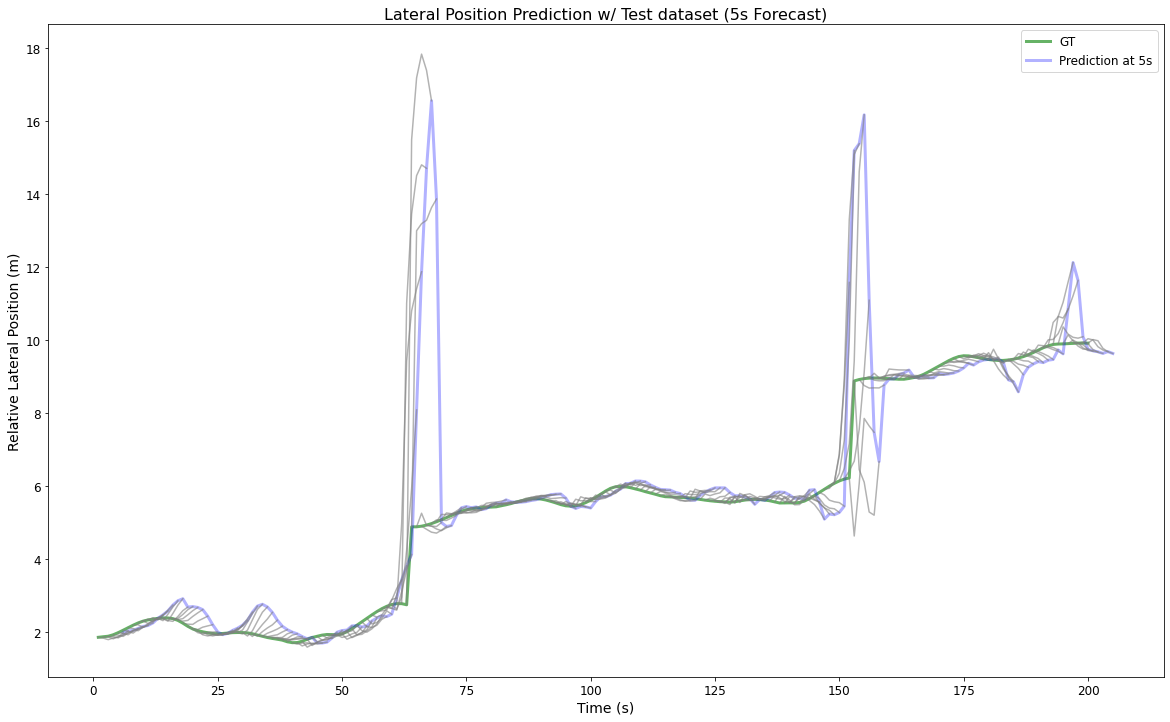

In [ ]:
plt.figure(figsize=(20, 12))  
plt.plot(range(1,201),y1_test_cnt[500:700,0]/3.28084,'green',label='GT',linewidth = 3, alpha=0.6)
plt.plot(range(6,206),testPredict_x_cnt[500:700,4]/3.28084,'blue',label='Prediction at 5s',linewidth = 3, alpha=0.3)
m = 1
for i in range(500,700):
  traj = np.insert(testPredict_x_cnt[i][:], 0, y1_test_cnt[500:700,0][m-1], axis=0)
  plt.plot(range(m,m+6),traj/3.28084,'gray', alpha=0.6)
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lateral Position Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Relative Lateral Position (m)', fontsize='14')
plt.show

<function matplotlib.pyplot.show>

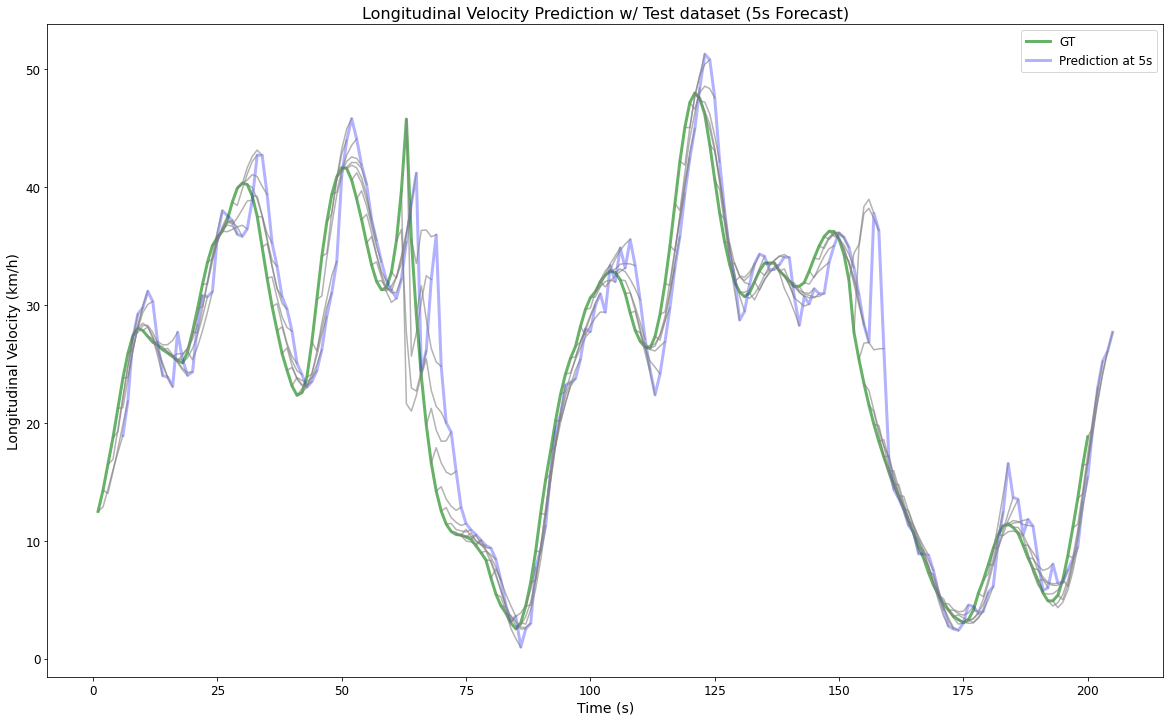

In [ ]:
plt.figure(figsize=(20, 12))  
plt.plot(range(1,201),y2_test_cnt[500:700,0]*1.09728,'green',label='GT',linewidth = 3, alpha=0.6)
plt.plot(range(6,206),testPredict_v_cnt[500:700,4]*1.09728,'blue',label='Prediction at 5s',linewidth = 3, alpha=0.3)
m = 1
for i in range(500,700):
  traj = np.insert(testPredict_v_cnt[i][:], 0, y2_test_cnt[500:700,0][m-1], axis=0)
  plt.plot(range(m,m+6),traj*1.09728,'gray', alpha=0.6)
  m = m + 1
plt.legend(loc='best', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Longitudinal Velocity Prediction w/ Test dataset (5s Forecast)', fontsize='16')
plt.xlabel('Time (s)', fontsize='14')
plt.ylabel('Longitudinal Velocity (km/h)', fontsize='14')
plt.show